In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [135]:
cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name']

In [136]:
df = pd.read_csv("auto-mpg.data", memory_map=True, names = cols, na_values='?', comment = '\t', sep = ' ',
                skipinitialspace=True)
data = df.copy()

In [137]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,NaN
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,NaN
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,NaN
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,NaN
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,NaN


### Problem Statement
Our goal is to predict the fuel efficiency for a vehicle based on an input containing other attributes of the vehicle.

## Exploratory Data Analysis

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      0 non-null      float64
dtypes: float64(6), int64(3)
memory usage: 28.1 KB


### Checking for nulls

In [139]:
df.isnull().sum()

mpg               0
cylinders         0
displacement      0
horsepower        6
weight            0
acceleration      0
model year        0
origin            0
car name        398
dtype: int64

### Categorical columns
The two categorical columns in our data are Origin and Cylinders. Let's look into the group sizes and distribution of values in these columns

In [140]:
df['cylinders'].value_counts()

cylinders
4    204
8    103
6     84
3      4
5      3
Name: count, dtype: int64

In [141]:
df['cylinders'].value_counts()/len(df)

cylinders
4    0.512563
8    0.258794
6    0.211055
3    0.010050
5    0.007538
Name: count, dtype: float64

In [142]:
df['origin'].value_counts()

origin
1    249
3     79
2     70
Name: count, dtype: int64

In [143]:
# Through EDA we found that the data has some rogue values for horsepower. Let's get rid of those before 
# moving any further
# df = df[df['horsepower'] != '?']

### Understanding correlations between the attributes
For this we use pairplot from the Seaborn library

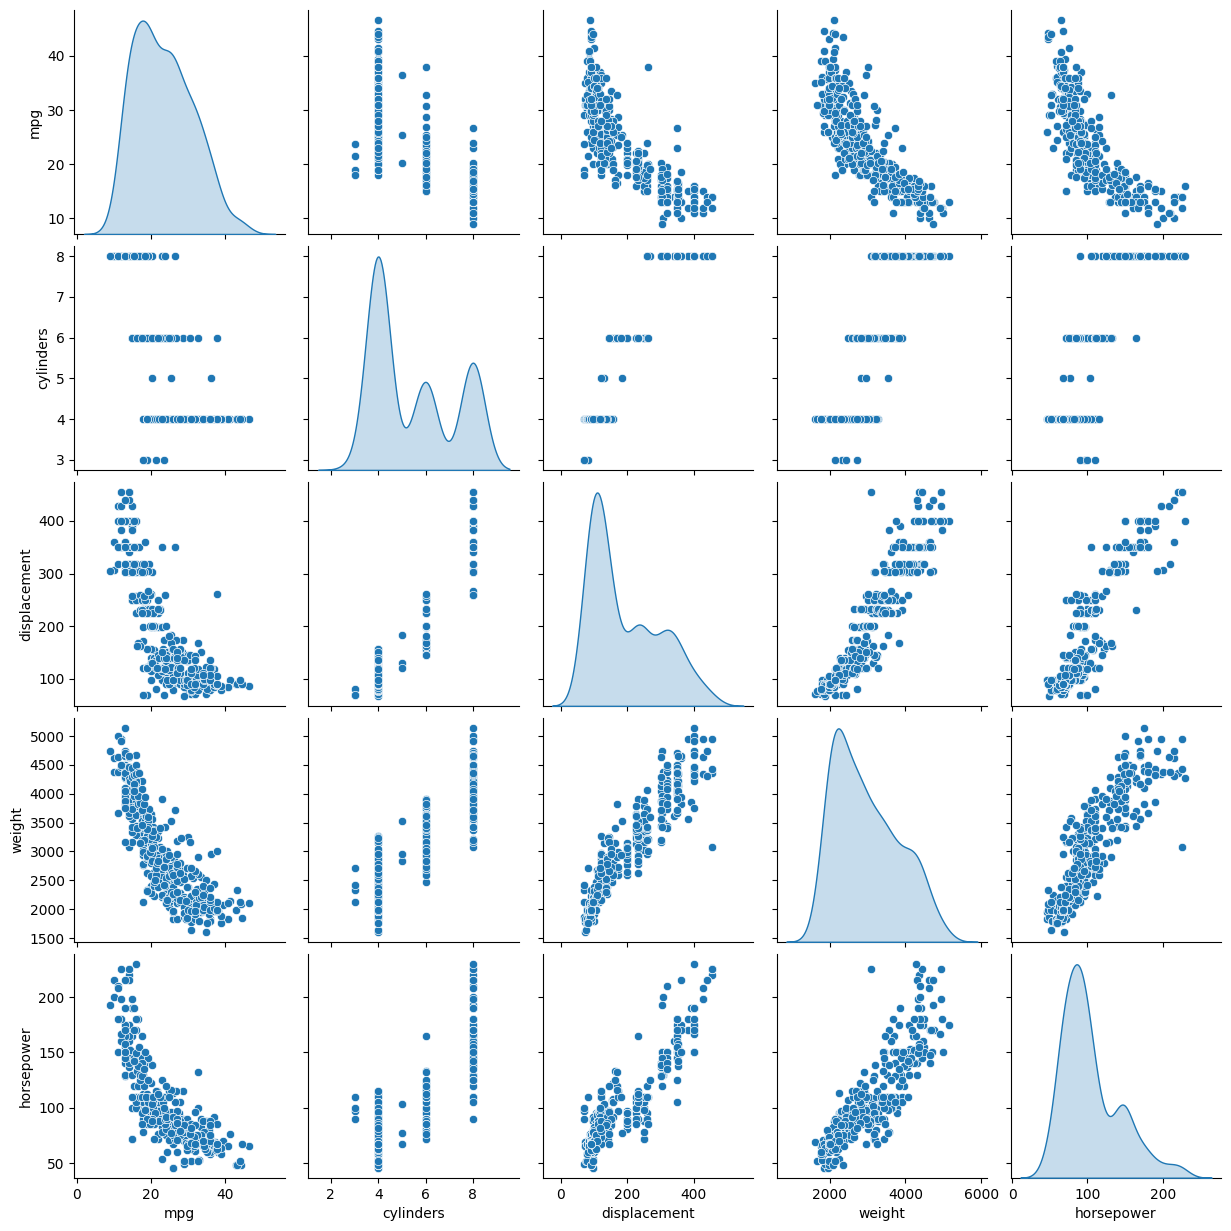

In [144]:
sns.pairplot(df[['mpg','cylinders','displacement',
                'weight', 'horsepower']], diag_kind = 'kde')

The above plot gives us a general idea of how the different attributes of the vehicle affect others. 
For instance:
1. Efficiency (mpg) is negatively correlated with weight, displacement and cylinders


### Splitting the data for testing
A Train/Test split is done to enable future testing on unseen/unbiased data.
The testing data should have a general representation of the population, and not be limited to a few specific categories. Stratified sampling gives us the ability to achieve that. 

Stratified sampling created homogenous subgroups called Strata from the population, and sample the right number of instances from each stratum, to ensure that the groups are equally represented in the testing data.

#### Using train_test_split from sklearn


In [145]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)
test_set.shape

(80, 9)

In [146]:
train_set['cylinders'].value_counts()/len(train_set)

cylinders
4    0.509434
8    0.248428
6    0.220126
3    0.012579
5    0.009434
Name: count, dtype: float64

In [147]:
test_set['cylinders'].value_counts()/len(train_set)

cylinders
4    0.132075
8    0.075472
6    0.044025
Name: count, dtype: float64

### StratifiedShuffleSplit from sklearn

In [148]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
# Using the Cylinders column for creating the strata
for train_index, test_index in split.split(df, df['cylinders']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [149]:
strat_train_set['cylinders'].value_counts()/len(strat_train_set)

cylinders
4    0.512579
8    0.257862
6    0.210692
5    0.009434
3    0.009434
Name: count, dtype: float64

In [150]:
strat_test_set['cylinders'].value_counts()/len(strat_test_set)
# The result below demonstrates that the testing and training datasets have a very similar distribution

cylinders
4    0.5125
8    0.2625
6    0.2125
3    0.0125
Name: count, dtype: float64

The origin column from the dataset has discrete country code values. We can map these codes to represent country names.

In [151]:
train_set['origin'] = train_set['origin'].map({1: 'India', 2: 'USA', 3 : 'Germany'})
train_set.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
3,16.0,8,304.0,150.0,3433.0,12.0,70,India,NaN
18,27.0,4,97.0,88.0,2130.0,14.5,70,Germany,NaN
376,37.0,4,91.0,68.0,2025.0,18.2,82,Germany,NaN
248,36.1,4,91.0,60.0,1800.0,16.4,78,Germany,NaN
177,23.0,4,115.0,95.0,2694.0,15.0,75,USA,NaN


In [152]:
data = strat_train_set.copy()

In [154]:
corr_matrix = data.corr()
corr_matrix['mpg'].sort_values(ascending=False)

mpg             1.000000
origin          0.582654
model year      0.577636
acceleration    0.411989
cylinders      -0.765693
horsepower     -0.777978
displacement   -0.800063
weight         -0.822723
car name             NaN
Name: mpg, dtype: float64

Occasionally in a dataset, we find that a combination of variables has a higher correlation to another variable, than a variable on it's own. Let's check our current dataset for such a possibility. 

In [156]:
data['displacement_on_power'] = data['displacement']/data['horsepower']
data['weight_on_cylinder'] = data['weight']/data['cylinders']
data['acceleration_on_power'] = data['acceleration']/data['horsepower']
data['acceleration_on_cyl'] = data['acceleration']/data['cylinders']
corr_matrix = data.corr()
corr_matrix['mpg'].sort_values(ascending = False)

mpg                      1.000000
acceleration_on_cyl      0.718888
acceleration_on_power    0.699560
origin                   0.582654
model year               0.577636
acceleration             0.411989
weight_on_cylinder       0.002289
displacement_on_power   -0.562725
cylinders               -0.765693
horsepower              -0.777978
displacement            -0.800063
weight                  -0.822723
car name                      NaN
Name: mpg, dtype: float64

### Segregating Target and Feature variables

In [179]:
data = strat_train_set.drop(["mpg", "car name"], axis = 1)
data_labels = strat_train_set["mpg"].copy()
data

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
145,4,83.0,61.0,2003.0,19.0,74,3
151,4,79.0,67.0,2000.0,16.0,74,2
388,4,156.0,92.0,2585.0,14.5,82,1
48,6,250.0,88.0,3139.0,14.5,71,1
114,4,98.0,90.0,2265.0,15.5,73,2
...,...,...,...,...,...,...,...
147,4,90.0,75.0,2108.0,15.5,74,2
156,8,400.0,170.0,4668.0,11.5,75,1
395,4,135.0,84.0,2295.0,11.6,82,1
14,4,113.0,95.0,2372.0,15.0,70,3


### Function to handle mapping for Origin attribute

In [180]:
def preprocess_origin(df):
    df['origin'] = df['origin'].map({1:"China", 2: "USA", 3:"Germany"})
    return df
data_tr = preprocess_origin(data)
data_tr.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
145,4,83.0,61.0,2003.0,19.0,74,Germany
151,4,79.0,67.0,2000.0,16.0,74,USA
388,4,156.0,92.0,2585.0,14.5,82,China
48,6,250.0,88.0,3139.0,14.5,71,China
114,4,98.0,90.0,2265.0,15.5,73,USA


### One-hot encoding for Origin

In [181]:
data_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318 entries, 145 to 362
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     318 non-null    int64  
 1   displacement  318 non-null    float64
 2   horsepower    314 non-null    float64
 3   weight        318 non-null    float64
 4   acceleration  318 non-null    float64
 5   model year    318 non-null    int64  
 6   origin        318 non-null    object 
dtypes: float64(4), int64(2), object(1)
memory usage: 19.9+ KB


In [182]:
# New dataframe with the categorical variable 'origin'
data_cat = data_tr[['origin']]
data_cat.head()

,origin
145,Germany
151,USA
388,China
48,China
114,USA


In [183]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
data_cat_1hot = cat_encoder.fit_transform(data_cat)
data_cat_1hot

<318x3 sparse matrix of type '<class 'numpy.float64'>'
	with 318 stored elements in Compressed Sparse Row format>

In [184]:
# data_cat_1hot is a sparse matrix. We convert it to an array to access the categories
data_cat_1hot.toarray()[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [185]:
cat_encoder.categories_

[array(['China', 'Germany', 'USA'], dtype=object)]

### Using SimpleImputer to handle missing values

In [194]:
num_data= data.iloc[:,:-1]
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318 entries, 145 to 362
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     318 non-null    int64  
 1   displacement  318 non-null    float64
 2   horsepower    314 non-null    float64
 3   weight        318 non-null    float64
 4   acceleration  318 non-null    float64
 5   model year    318 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 17.4 KB


In [195]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(num_data)

SimpleImputer(strategy='median')

In [196]:
imputer.statistics_

array([   4. ,  146. ,   92. , 2844. ,   15.5,   76. ])

In [197]:
# imputing the missing values by transforming the dataframe
imputed = imputer.transform(num_data)
imputed

array([[   4. ,   83. ,   61. , 2003. ,   19. ,   74. ],
       [   4. ,   79. ,   67. , 2000. ,   16. ,   74. ],
       [   4. ,  156. ,   92. , 2585. ,   14.5,   82. ],
       ...,
       [   4. ,  135. ,   84. , 2295. ,   11.6,   82. ],
       [   4. ,  113. ,   95. , 2372. ,   15. ,   70. ],
       [   6. ,  146. ,  120. , 2930. ,   13.8,   81. ]])

In [198]:
data_tr = pd.DataFrame(imputed, columns=num_data.columns, index = num_data.index)
data_tr.info()


<class 'pandas.core.frame.DataFrame'>
Index: 318 entries, 145 to 362
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     318 non-null    float64
 1   displacement  318 non-null    float64
 2   horsepower    318 non-null    float64
 3   weight        318 non-null    float64
 4   acceleration  318 non-null    float64
 5   model year    318 non-null    float64
dtypes: float64(6)
memory usage: 17.4 KB


### Creating new attributes using BaseEstimator and Transformer

In [199]:
num_data.head()

,cylinders,displacement,horsepower,weight,acceleration,model year
145,4,83.0,61.0,2003.0,19.0,74
151,4,79.0,67.0,2000.0,16.0,74
388,4,156.0,92.0,2585.0,14.5,82
48,6,250.0,88.0,3139.0,14.5,71
114,4,98.0,90.0,2265.0,15.5,73


Creating the class AddCustomAttribute to add the customer attributes to the already transformed data. As an option, we will also have acc_on_power as a boolean, to indicate if we want to add the column to our data or not. 

In [203]:
from sklearn.base import BaseEstimator, TransformerMixin

acc_ix, hpower_ix, cyl_ix = 4,2,0

class AddCustomAttribute(BaseEstimator, TransformerMixin):
    def __init__(self, acc_on_power=True):
        self.acc_on_power = acc_on_power

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        acc_on_cyl = X[:, acc_ix] / X[:, cyl_ix]
        if self.acc_on_power:
            acc_on_power = X[:, acc_ix] / X[:, hpower_ix]
            return np.c_[X, acc_on_power, acc_on_cyl]

        return np.c_[X, acc_on_cyl]

attr_adder = AddCustomAttribute(acc_on_power=True)
data_tr_extra_attrs = attr_adder.transform(data_tr.values)
data_tr_extra_attrs[0]

array([4.0000000e+00, 8.3000000e+01, 6.1000000e+01, 2.0030000e+03,
       1.9000000e+01, 7.4000000e+01, 3.1147541e-01, 4.7500000e+00])

### Bringing it all together into one pipepine: SKLearn.Pipeline

In [204]:
from sklearn.pipeline import Pipeline
# We will also scale the numerical attributes using the StandardScaler function

from sklearn.preprocessing import StandardScaler

numerics = ['float64', 'int64']

num_data = data_tr.select_dtypes(include = numerics)

### Constructing the pipelines
#### Numeric attributes
In the next step, we create a pipeline for just the numeric attributes. The pipeline will have the following steps:
..Impute -> Add attributes -> Scale the attributes


In [205]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attrs_adder', AddCustomAttribute()),
    ('std_scaler', StandardScaler()),
])

In [208]:
numeric_data_tr = numeric_pipeline.fit_transform(num_data)
numeric_data_tr[0]

array([-0.85657842, -1.07804475, -1.15192977, -1.17220298,  1.21586943,
       -0.54436373,  1.70952741,  1.29565517])

#### Numerical and Categorical attributes

In [209]:
from sklearn.compose import ColumnTransformer

numeric_attrs = list(num_data)
categorical_attrs = ['origin']

full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_attrs),
    ("categorical", OneHotEncoder(), categorical_attrs)
])

prepared_data = full_pipeline.fit_transform(data)
prepared_data[0]

array([-0.85657842, -1.07804475, -1.15192977, -1.17220298,  1.21586943,
       -0.54436373,  1.70952741,  1.29565517,  0.        ,  1.        ,
        0.        ])

## Defining functions to perform above transformations:

In [216]:
def numeric_pipeline_transformer(data):
    "Transforms numerical attributes"
    numerics = ['float64', 'int64']
    numeric_attrs = data.select_dtypes(include = numerics)
    
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('attribute_adder', AddCustomAttribute()),
        ('std_scaler', StandardScaler())
    ])
    return numeric_attrs, numeric_pipeline


def pipeline_transformer(data):
    categorical_attrs = ['origin']
    numeric_attrs, numeric_pipeline = numeric_pipeline_transformer(data)
    full_pipeline = ColumnTransformer([
        ('numeric', numeric_pipeline, list(numeric_attrs)),
        ('categorical', OneHotEncoder(), categorical_attrs),
    ])
    prepared_data = full_pipeline.fit_transform(data)
    return prepared_data

## Selecting and Training Models:
1. Linear Regression
2. Decision Tree
3. Random Forest
4. SVM regressor

### Linear Regression

In [217]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(prepared_data, data_labels)

LinearRegression()

In [219]:
# Testing the predictions made with LR
sample_data = data.iloc[:5]
sample_labels = data_labels.iloc[:5]

sample_data_prepared = pipeline_transformer(sample_data)


In [220]:
print("Prediction of Samples:", lr.predict(sample_data_prepared))

Prediction of Samples: [29.08069379 27.78336755 26.08031176 12.70419279 22.23454159]


### Calculating the Error Metric: Root Mean Squared error (RMSE)

In [223]:
from sklearn.metrics import mean_squared_error
mpg_prediction = lr.predict(prepared_data)
lr_rmse = mean_squared_error(data_labels, mpg_prediction)
lr_rmse = np.sqrt(lr_rmse)
lr_rmse

2.959040222576087

### Decision Tree

In [224]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(prepared_data, data_labels)

DecisionTreeRegressor()

In [225]:
mpg_prediction = tree_reg.predict(prepared_data)
tree_rmse = mean_squared_error(data_labels, mpg_prediction)
tree_rmse = np.sqrt(tree_rmse)
tree_rmse

0.0

The above operation results in a 0.0 for the RMSE. It means we have very likely overfit the data. 
Let's check for what's going on.

### K-fold Cross Validation: Model evaluation
We use SKLearn's K-fold cross validation. It randomly splits the training set into k distinct subsets - known as folds. It then trains and evaluates the model k times, picking a different fold for evaluation every time and training on the other k-1 folds. The result is an array containing the scores from the k runs.


In [227]:
# For the Tree Regression Model
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,
                        prepared_data,
                        data_labels,
                        scoring = "neg_mean_squared_error",
                        cv = 10)
tree_reg_rmse_scores = np.sqrt(-scores)
tree_reg_rmse_scores

array([3.08848668, 3.115987  , 2.89352726, 3.07449183, 2.38792535,
       3.14026273, 3.55118818, 4.43815136, 4.12060127, 2.46183776])

In [228]:
tree_reg_rmse_scores.mean()

3.227245943135155

In [229]:
# For the LR model
scores = cross_val_score(lr,
                        prepared_data,
                        data_labels,
                        scoring = "neg_mean_squared_error",
                        cv = 10)

lr_rmse_scores = np.sqrt(-scores)
lr_rmse_scores

array([3.43254597, 3.45157629, 3.6621715 , 2.59652976, 2.48023405,
       2.74798115, 3.32524647, 2.42208917, 3.78133275, 2.8573747 ])

In [230]:
lr_rmse_scores.mean()

3.0757081793709324

### Random Forest Model

In [235]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(prepared_data, data_labels)
forest_reg_cv_scores = cross_val_score(forest_reg,
                                       prepared_data,
                                       data_labels,
                                       scoring = "neg_mean_squared_error",
                                       cv = 10)
forest_reg_rmse_scores = np.sqrt(-forest_reg_cv_scores)
forest_reg_rmse_scores

array([2.11228937, 2.57501615, 2.77687097, 2.39171812, 2.01409999,
       2.44508952, 2.83826599, 2.55581393, 4.14487584, 1.88093657])

In [236]:
forest_reg_rmse_scores.mean()

2.57349764498838

### Support Vector Machine Regressor

In [237]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(prepared_data, data_labels)
svm_cv_scores = cross_val_score(svm_reg,
                               prepared_data,
                               data_labels,
                               scoring = 'neg_mean_squared_error',
                               cv = 10)
svm_rmse_scores = np.sqrt(-svm_cv_scores)
svm_rmse_scores.mean()

3.086591620802806

### Hyperparameter Tuning using GridSearchCV

In [243]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 20],
    'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
]


forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, 
                           param_grid,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True,
                          cv = 10)

grid_search.fit(prepared_data, data_labels)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 20]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [244]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 20}

In [245]:
cv_scores

NameError: name 'cv_scores' is not defined

In [246]:
cv_scores = grid_search.cv_results_

for mean_score, params in zip(cv_scores['mean_test_score'], cv_scores["params"]):
    print(np.sqrt(-mean_score), params)

3.5909998164716805 {'max_features': 2, 'n_estimators': 3}
3.098781927707058 {'max_features': 2, 'n_estimators': 10}
2.936630865759922 {'max_features': 2, 'n_estimators': 20}
3.2789893859799513 {'max_features': 4, 'n_estimators': 3}
2.8855940819257935 {'max_features': 4, 'n_estimators': 10}
2.80686111062782 {'max_features': 4, 'n_estimators': 20}
3.3996884081341094 {'max_features': 6, 'n_estimators': 3}
2.891753570012047 {'max_features': 6, 'n_estimators': 10}
2.638943289649837 {'max_features': 6, 'n_estimators': 20}
3.158596678100956 {'max_features': 8, 'n_estimators': 3}
2.7958736912780315 {'max_features': 8, 'n_estimators': 10}
2.742837339024459 {'max_features': 8, 'n_estimators': 20}
3.1857087524405525 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
2.87407408652573 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
3.2517049050346687 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
2.9456306146124183 {'bootstrap': False, 'max_features': 3, 'n_estimator

### Checking Feature Importance

In [247]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.08802548, 0.3157526 , 0.15839349, 0.16984125, 0.0180778 ,
       0.11102682, 0.03139141, 0.10025129, 0.00199616, 0.00380469,
       0.00143903])

In [249]:
extra_attribs = ["acc_on_power", "acc_on_cyl"]
numerics = ["float64", "int64"]

numeric_attribs = list(data.select_dtypes(include = numerics))
attrs = numeric_attribs + extra_attribs
sorted(zip(attrs, feature_importances), reverse = True)

[('weight', 0.16984124584041022),
 ('model year', 0.11102681698193215),
 ('horsepower', 0.15839348541340512),
 ('displacement', 0.3157525984378579),
 ('cylinders', 0.08802547545470127),
 ('acceleration', 0.018077797396195368),
 ('acc_on_power', 0.03139141331668306),
 ('acc_on_cyl', 0.1002512880865909)]

### Evaluating the complete pipeline with Test data

In [252]:
final_model = grid_search.best_estimator_


X_test = strat_test_set.drop("mpg", axis = 1)
y_test = strat_test_set["mpg"].copy()

X_test_preprocessed = preprocess_origin(X_test)
X_test_prepared = pipeline_transformer(X_test_preprocessed)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

3.0238980430894173

### Encapsulate the entire flow into a single function 

In [253]:
def predict_mpg(config, model):
    
    if type(config) == dict:
        df = pd.DataFrame(config)
    else:
        df = config
        
    preproc_df = preprocess_origin(df)
    prepared_df = pipeline_transformer(preproc_df)
    
    y_pred = model.predict(prepared_df)
    
    return y_pred

In [255]:
# Test the flow using a random sample

vehicle_config = {
    'cylinders' : [4,6,8],
    'displacement' : [155.0, 160.0, 165.5],
    'horsepower' : [93.0, 130.0, 98.0],    
    'weight': [2500.0, 3150.0, 2600.0],
    'acceleration': [15.0, 14.0, 16.0],
    'model Year': [81, 80, 78],
    'origin': [3, 2, 1]
}

predict_mpg(vehicle_config, final_model)

array([35.085, 17.91 , 24.02 ])

## Save the model

In [257]:
import pickle

with open("model.bin", 'wb') as f_out:
    pickle.dump(final_model, f_out)
    f_out.close()

### loading the model from the saved pickle file

In [260]:
with open("model.bin", 'rb') as f_in:
    model = pickle.load(f_in)
predict_mpg(vehicle_config, model)

array([35.085, 17.91 , 24.02 ])

# Gradio App! 